## Image classification with deep learning methods.

-- Description --

When you train the network, it is recommended to use the GPU resources of your computer.
This will help you to learn the "know how" of setting up a working Python environment on your computer.
In the case of unavailable Nvidia hardware or problems with your Python environment you can use Google Colab.
Please go to the menu, Runtime - Change runtime type, and select **GPU** as the hardware accelerator.
Although you used your computer successfuly it is highly recommended to give a try to Google Colab environment.


In [1]:
# Import libraries
# These libraries should be sufficient for this Practice.
# However, if any other library is needed, please install it by yourself.

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torch.utils.data as data
import numpy as np
import time
import os
import random
import matplotlib.pyplot as plt
from matplotlib import colors
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import roc_auc_score

In [2]:
# Install and import the MedMNIST package and datasets.

!pip install medmnist
import medmnist
from medmnist import info

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached 

## Download the imaging dataset

You can browse the imaging datasets on their webpage https://medmnist.com/, and download them as such:


In [3]:
from medmnist import *

# Preprocesado de datos mediante la definición de la transformación de datos
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

blood_train_dataset = BloodMNIST(split="train", transform=data_transform, download=True, size= 28)
blood_valid_dataset = BloodMNIST(split="val", transform=data_transform, download=True, size= 28)
blood_test_dataset = BloodMNIST(split="test", transform=data_transform, download=True, size= 28)

100%|██████████| 35461855/35461855 [00:02<00:00, 14609613.38it/s]


Using downloaded and verified file: /root/.medmnist/bloodmnist.npz
Using downloaded and verified file: /root/.medmnist/bloodmnist.npz


## Visualize the imaging dataset

You can find relevant information about the datasets in the info.INFO dictionary.

For visualizing the images, you can use the montage method, though we recomend
you practice accesing the individual images and labels.



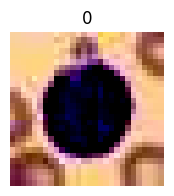

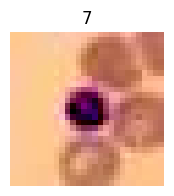

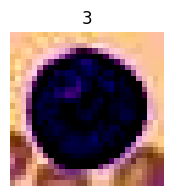

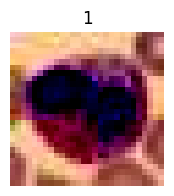

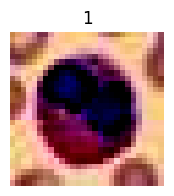

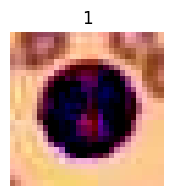

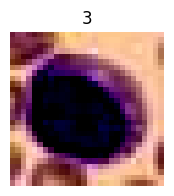

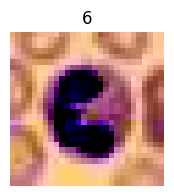

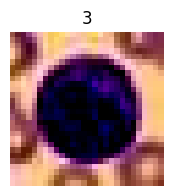

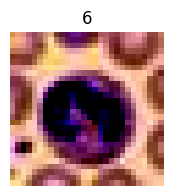

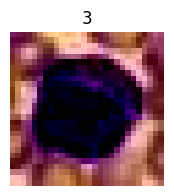

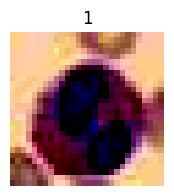

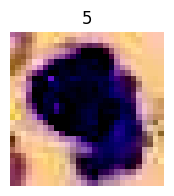

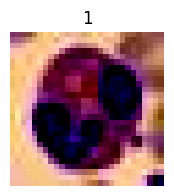

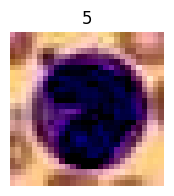

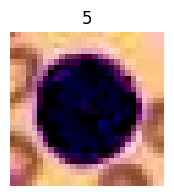

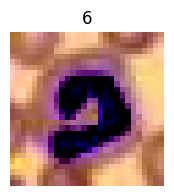

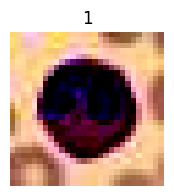

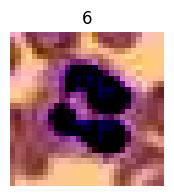

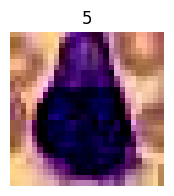

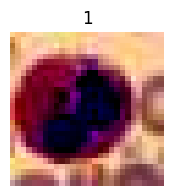

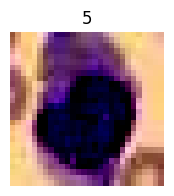

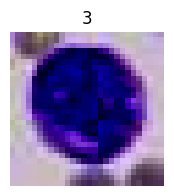

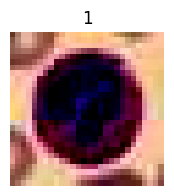

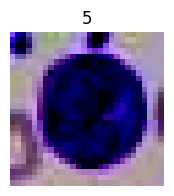

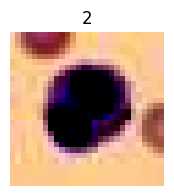

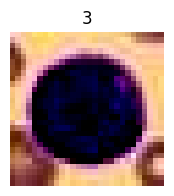

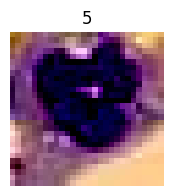

In [ ]:
# Your code

import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import tensorflow as tf
from medmnist import INFO, Evaluator

info = INFO['bloodmnist']
data_labels = info['label']

# Función que permite visualizar los aspectos fundamentales sobre cada
# dataset que se haya descargado/cargado previamente.
def dataset_visualizer(dataset,length_montage):

  for i in range(0,length_montage*length_montage):
    img = dataset[i][0]
    label = str(dataset[i][1]).replace('[','')
    figure = plt.figure(figsize=(2,2))
    plt.imshow(img.permute(1,2,0))
    plt.title(data_labels[label.replace(']','')])
    plt.axis("off")
  plt.show()

# Visualizador de las imágenes a través de un pipeline DataLoader
def dataloader_visualizer(dataset,num_batches):
  data_loader = data.DataLoader(dataset,batch_size=28,shuffle=True)
  for batch_idx, (features, labels) in enumerate(data_loader):
      if batch_idx >= num_batches:
        break
      for i in range(len(features)):
        img = features[i].squeeze()
        label = str(labels[i]).replace('tensor([','').replace('])','')
        plt.figure(figsize=(2,2))
        plt.title(label)
        plt.imshow(img.permute(1,2,0))
        plt.axis('off')
        plt.show()


#dataset_visualizer(blood_train_dataset,5)
dataloader_visualizer(blood_train_dataset,1)
#dataset_visualizer(blood_valid_dataset,20)
#dataset_visualizer(blood_test_dataset,20)


#Generate a dataloader

A convinient option for accessing data in torch is with the use of the Dataloader class. These work directly when given a MNIST dataset as input.
You can also apply any necesary preprocesing steps directly as you load the data with the Transforms package and the transform MNIST argument.

Choose apropiate values for the training hiperparameters (you can experiment with sampling strategies if you want) and implement the adecuate preprocesing steps. Finally, choose an Mnist dataset and create the dataloader for the training, validation and test splits.

In [4]:
# Parameters
NUM_EPOCHS = 20
BATCH_SIZE = 128
lr = 0.0001
DOWNLOAD_OK = True
data_flag = 'bloodmnist'
im_size = 28

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
num_classes = len(info['label'])

# Tupla que contiene los valores asociados a los parámetros mostrados anteriormente,
# con el fin de mejorar la organización de dichos parámetros.
parameters = {"num_epochs": NUM_EPOCHS, "batch_size": BATCH_SIZE, "lr": lr, "download_ok": DOWNLOAD_OK,
              "data_flag": data_flag, "im_size": im_size,"info_task": task, "n_channels": n_channels,
              "num_classes": num_classes}

# Función que permite encapsular la carga de los datasets
def dataset_loading(train_dataset,valid_dataset,test_dataset,parameters):
  train_loader = data.DataLoader(dataset=train_dataset, batch_size=parameters["batch_size"], shuffle=True)
  valid_loader = data.DataLoader(dataset=valid_dataset, batch_size=parameters["batch_size"], shuffle=False)
  test_loader = data.DataLoader(dataset=test_dataset, batch_size=parameters["batch_size"],shuffle=False)

  return train_loader, valid_loader, test_loader

#Define loss function and optimizer
#Your code

# Función que representa la métrica de error asociada al modelo predictivo
def loss_function(task):
  return torch.nn.CrossEntropyLoss()

# Función que representa el optimizador utilizado para el modelo predictivo
def model_optimizer(model):
  #return optim.SGD(model.parameters(), lr=lr, momentum=0.9)
  return torch.optim.Adam(model.parameters(),lr=lr)

train_loader,valid_loader,test_loader = dataset_loading(blood_train_dataset,
                                                        blood_valid_dataset,
                                                        blood_valid_dataset,
                                                        parameters)

print(train_loader)
print(valid_loader)
print(test_loader)
print(len(train_loader))
print(len(valid_loader))
print(len(test_loader))


94
14
14


#Create a deep learning model

In [5]:
# Define a simple CNN model

class Net(nn.Module):
    def __init__(self, in_channels, num_classes, im_size):
        super(Net, self).__init__()
        #Define the desired deep learning model
        #Your code

        #Primera capa del modelo de red neuronal convolucional
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes))

        #End your code

    def forward(self, x):
        #Your code

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        #End your code

class FCNet():
  def __init__(self,in_channels, num_classes, im_size):



#model = Net(in_channels=n_channels, num_classes=num_classes, im_size = im_size)

#Train Model

Implement the main traning loop to train the deep learning model.
This should include the forward and backward passes. You can find information about how to do this with torch in https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#id14

In [6]:
# Train the model

def train_epoch(model,train_loader,optimizer,criterion,task):
  #model.train()

  losses = []
  correct = 0
  total = 0

  #for inputs, targets in tqdm(train_loader):
  for inputs,targets in tqdm(train_loader):
    optimizer.zero_grad()
    outputs = model(inputs)

    print(outputs)

    if task == 'multi-label, binary-class':
      targets = targets.to(torch.float32)
    else:
      targets = torch.squeeze(targets,1).long()
    loss = loss_function(parameters["info_task"])

    losses.append(loss)
    loss.backward()
    optimizer.step()

  total += targets.shape[0]
  correct += torch.sum(outputs.max(1)[1] == targets).item()

  return {"train_acc" : np.round(correct/total,3),
          "train_loss" : np.round(np.mean(losses),3),
  }

def train_epoch2(model, train_loader, optimizer, criterion, task):
    model.train()

    losses = []
    correct = 0
    total = 0

    for inputs, targets in tqdm(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)

        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
        else:
            targets = targets.squeeze(1).long()

        loss = criterion(outputs, targets)
        losses.append(loss.item())  # Append the loss item, not the loss tensor
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    return {
        "train_acc": np.round(correct / total, 3),
        "train_loss": np.round(np.mean(losses), 3),
    }

def validate_epoch(model,test_loader,device,criterion,task):
  model.eval()

  losses = []
  correct = 0
  total = 0
  with torch.no_grad():
    for inputs, targets in tqdm(test_loader):
      outputs = model(inputs)

      if task == 'multi-label, binary-class':
        targets = targets.to(torch.float32)
        loss = criterion(outputs,targets)
        m = nn.Sigmoid()
        outputs = m(outputs)
      else:
        targets = torch.squeeze(targets,1).long()
        loss = criterion(outputs,targets)

      losses.append(loss.item())
      total += targets.shape[0]
      correct += (outputs.max(1)[1] == targets).sum().cpu().numpy()

    return {
      "val_acc": np.round(correct/total,3),
      "val_err": np.round(np.mean(losses),3),
    }


def centralized_training(train_loader,test_loader,parameters):
  centralized_model = Net(in_channels=parameters["n_channels"],
                          num_classes=parameters["num_classes"],
                          im_size=parameters["im_size"])
  optimizer = model_optimizer(centralized_model)
  criterion = loss_function(parameters["info_task"])

  for epoch in range(parameters["num_epochs"]):
    train_history = train_epoch2(centralized_model,train_loader,optimizer,criterion,task)
    valid_history = validate_epoch(centralized_model,test_loader,criterion,task)
    print(f'Epoch {epoch}: {train_history} - {valid_history}')



centralized_training(train_loader,test_loader,parameters)
#for epoch in range(NUM_EPOCHS):

  #model.train()
  #for inputs, targets in tqdm(train_loader):
    # forward + backward + optimize
    #optimizer = model_optimizer(model)
    #optimizer.zero_grad()
    #outputs = model(inputs)
    #Your code

    #if task == 'multi-label, binary-class':
    #  targets = targets.to(torch.float32)
    #  loss = loss_function(task)(outputs, targets)
    #else:
    #  targets = targets.squeeze().long()
    #  loss = loss_function(task)(outputs, targets)

    #loss.backward()
    #optimizer.step()

  0%|          | 0/94 [00:00<?, ?it/s]


TypeError: cross_entropy_loss(): argument 'input' (position 1) must be Tensor, not NoneType

#Evaluation

Finally, implement the evaluation of the object clasification task. You can implement any metric you want, though the most common are accuracy and AUC (one class against all for the multiclass task). You can use torch.no_grad() for speeding up predictions when no gradients are needed.

How do you compare with the MedMNIST benchmarks?

In [ ]:
# Evaluation

# Your code
def model_evaluation_dataset(split):
  model.eval()

  y_true = torch.tensor([])
  y_score = torch.tensor([])

  data_loader = train_loader_at_eval if split == 'train' else test_loader

  with torch.no_grad():
    for inputs, targets in data_loader:
      outputs = model(inputs)

      if task == 'multi-label, binary-class':
        targets = targets.to(torch.float32)
        outputs = outputs.softmax(dim=-1)
      else:
        targets = targets.squeeze().long()
        outputs = outputs.softmax(dim=-1)
        targets = targets.float().resize_(len(targets), 1)

      y_true = torch.cat((y_true, targets), 0)
      y_score = torch.cat((y_score, outputs), 0)

    y_true = y_true.numpy()
    y_score = y_score.detach().numpy()

    evaluator = Evaluator(data_flag, split)
    metrics = evaluator.evaluate(y_score)

    print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))

print('==> Evaluating ...')
model_evaluation_dataset('test')

==> Evaluating ...


NameError: name 'test' is not defined